In [1]:
import os
import sys
import json
import time
import gspread
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from scipy import signal, fftpack, stats, ndimage
import statsmodels.stats.multitest as multitest

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    get_stim_events,
    get_evoked_traces,
    get_evoked_firing_rates,
    find_nearest_ind
)
from allensdk.brain_observatory.ecephys.lfp_subsampling.subsampling import remove_lfp_offset
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [4]:
%matplotlib notebook

In [5]:
plt.rcParams.update({'font.size': 12})

Load CCF for identifying cortical areas

In [6]:
mcc = MouseConnectivityCache(resolution=10)
str_tree = mcc.get_structure_tree()

Load Zap_Zip-log_exp to get metadata for experiments

In [7]:
_gc = gspread.service_account() # need a key file to access the account
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
zzmetadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

Define areas of interest to plot population activity

In [8]:
areas_of_interest = {
    'MO': [
        'MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b',
        'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'
    ],
    'ACA': [
        'ACAd1', 'ACAd2/3', 'ACAd5', 'ACAd6a', 'ACAd6b',
        'ACAv1', 'ACAv2/3', 'ACAv5', 'ACAv6a', 'ACAv6b'
    ],
    'SS': [
        'SSp-bfd1', 'SSp-bfd2/3', 'SSp-bfd4', 'SSp-bfd5', 'SSp-bfd6a', 'SSp-bfd6b',
        'SSp-ll1', 'SSp-ll2/3', 'SSp-ll4', 'SSp-ll5', 'SSp-ll6a', 'SSp-ll6b',
        'SSp-tr1', 'SSp-tr2/3', 'SSp-tr4', 'SSp-tr5', 'SSp-tr6a', 'SSp-tr6b'
    ],
    'VIS': [
        'VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b',
        'VISam1', 'VISam2/3', 'VISam4', 'VISam5', 'VISam6a', 'VISam6b',
        'VISpm1', 'VISpm2/3', 'VISpm4', 'VISpm5', 'VISpm6a', 'VISpm6b',
        'VISrl1', 'VISrl2/3', 'VISrl4', 'VISrl5', 'VISrl6a', 'VISrl6b',
    ],
    'MO-TH': [
        'AV', 'CL', 'MD', 'PO', 'RT', 'VAL', 'VPL', 'VPM', 'VM'
    ],
#     'VIS-TH': [
#         'LD', 'LGd-sh', 'LGd-co', 'LGd-ip', 'LGv', 'LP', 'MGd', 'MGm', 'MGv'
#     ] # CK said MGd/m/v is auditory?
}

area_colors = {
    'MO': 'blue',
    'ACA': 'deepskyblue',
    'SS': 'blueviolet',
    'VIS': 'green',
    'MO-TH': 'steelblue',
}

In [9]:
state_colors = {
    'awake': (120/255, 156/255, 74/255),
    'anesthetized': (130/255, 122/255, 163/255),
    'recovery': (93/255, 167/255, 229/255)
}

#### Functions

In [10]:
def classify_response(row, alpha=0.05):
    if row['corr_pval'] < alpha and row['delta_spike_count'] > 0:
        return 'excited'
    elif row['corr_pval'] < alpha and row['delta_spike_count'] < 0:
        return 'inhibited'
    else:
        return 'ns'

### Define data path

In [11]:
rec_folder = r'F:\EEG_exp\mouse571619\estim2_2021-03-19_10-09-01\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

comp_states = {
    'MOs_superficial': {'awake': [0], 'anesthetized': [3]},
    'MOs_deep': {'awake': [1], 'anesthetized': [2]},
}

Experiment type: electrical stimulation
SomnoSuite log file not found.


In [12]:
# Make a folder in my OneDrive to save plots
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)
figsavedir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\manuscript_figs\pop_timing'
if not os.path.exists(figsavedir):
    os.mkdir(figsavedir)
    
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

estim2


#### Load stim table and speed signal

In [13]:
stim_log = pd.read_csv(exp.stimulus_log_file)
stim_log = stim_log.astype({'parameter': str})
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,good
0,biphasic,40,0.0004,319.16422,319.16462,0,True
1,biphasic,20,0.0004,322.69724,322.69764,0,True
2,biphasic,40,0.0004,326.75887,326.75927,0,True
3,biphasic,60,0.0004,331.14116,331.14156,0,True
4,biphasic,60,0.0004,335.31077,335.31117,0,True


In [14]:
run_signal, run_timestamps = exp.load_running()

In [15]:
## Grab exp metadata from Zap_Zip-log_exp ##
exp_meta = zzmetadata[(
    (zzmetadata['mouse_name'].str.contains(exp.mouse)) &
    (zzmetadata['exp_name'].str.contains(os.path.basename(os.path.dirname(exp.experiment_folder))))
)].squeeze()
        
## Get PCI_stim_amp from metadata ##
currentstr = exp_meta['Current (uA)'].replace(' ','')
currents_list = []
for char in currentstr.split('/'):
    if char.isdecimal():
        currents_list.append(char)
if len(currents_list) > 1:
    PCI_stim_amp = currents_list[1]
elif len(currents_list) == 1:
    PCI_stim_amp = currents_list[0]
else:
    print('No stim current listed in Zap_Zip-log_exp')
print(currents_list)
print(PCI_stim_amp)

['20', '40', '60']
40


#### Load unit data

In [16]:
probe_list = [x.replace('_sorted', '') for x in exp.experiment_data if 'probe' in x]
print(probe_list)

['probeB', 'probeC', 'probeF']


In [17]:
probe_unit_data = {}
total_units = 0
for probei in probe_list:
    print(probei)
    probe_unit_data[probei] = {}
    
    ## Load probe_info.json ##
    with open(exp.ephys_params[probei]['probe_info']) as data_file:
        data = json.load(data_file)
    npx_allch = np.array(data['channel']) # this is an array from 0 to 384
    surface_ch = int(data['surface_channel']) # the electrode we said was at the brain surface
    allch_z = np.array(data['vertical_pos']) # vertical pos of each elec (um), rel to the tip (ch 0 is 20 um from tip)
    ref_mask = np.array(data['mask']) # contains a False for Npx reference channels and "bad chs"
    print(' surface channel: {:d}'.format(surface_ch))
    
    ## Get all ch depths ##
    npx_chs = np.array([x for x in npx_allch if ref_mask[x] and x <= surface_ch])
    probe_unit_data[probei]['ch_depths'] = allch_z[surface_ch] - allch_z
    
    ## Select units and get peak chs ##
    select_units, peak_chs, unit_metrics = exp.get_probe_units(probei)
    unit_metrics['cell_type'] = unit_metrics['duration'].apply(lambda x: 'FS' if x <= 0.4 else 'RS')
    print(' unit count: {:d}'.format(len(select_units)))
    
    ## Sort units ##
    probe_unit_data[probei]['units'] = select_units[np.squeeze(np.argsort(peak_chs))]
    probe_unit_data[probei]['chs'] = peak_chs[np.squeeze(np.argsort(peak_chs))]
    probe_unit_data[probei]['cell_type'] = unit_metrics['cell_type'].values[np.squeeze(np.argsort(peak_chs))]
    if 'area' in unit_metrics.columns:
        probe_unit_data[probei]['areas'] = unit_metrics.area.values[np.squeeze(np.argsort(peak_chs))]
    else:
        print(' unit metrics file does not have area assignments.')
    total_units += len(probe_unit_data[probei]['units'])
            
    ## Load spike times and cluster ids ##
    probe_unit_data[probei]['spike_times'] = np.load(exp.ephys_params[probei]['spike_times'])
    probe_unit_data[probei]['spike_clusters'] = np.load(exp.ephys_params[probei]['spike_clusters'])
print('Total unit count: {:d}'.format(total_units))

probeB
 surface channel: 340
 unit count: 218
probeC
 surface channel: 350
 unit count: 343
probeF
 surface channel: 285
 unit count: 298
Total unit count: 859


## Get trial times

In [18]:
current_level = ['low', 'medium', 'high']
test_states = ['awake', 'anesthetized']

In [19]:
rest_trials_only = True
all_event_times = {}
for expdes, state_sweeps in comp_states.items():
    print(expdes)
    all_event_times[expdes] = {}
    for leveli, parami in zip(current_level, currents_list):
        print('biphasic - {} \u03bcA ({})'.format(parami, leveli))
        all_event_times[expdes][leveli] = {}
        for statei in test_states:
            sweeps = state_sweeps[statei]
            ## Get all event times for statei ##
            state_events = []
            for sweepi in sweeps:
                events = get_stim_events(stim_log, 'biphasic', parami, sweepi)
                if len(events) == 0:
                    continue
                state_events.append(events)
            state_events = np.concatenate(state_events)

            ## Get mean speed for all events ##
            rinds = np.arange(-int(0.5 * 100), int(0.5 * 100))
            event_inds = np.array([find_nearest_ind(run_timestamps, x) for x in state_events])
            mean_speed = np.mean(run_signal[np.repeat([rinds], len(event_inds), axis=0).T + event_inds], axis=0)
            rest_events = np.nonzero(mean_speed == 0)[0]
            print(' {} state: resting trials {:d}/{:d}'.format(statei, len(rest_events), len(state_events)))

            if rest_trials_only:
                all_event_times[expdes][leveli][statei] = state_events[rest_events]
            else:
                all_event_times[expdes][leveli][statei] = state_events
    print('')

MOs_superficial
biphasic - 20 μA (low)
 awake state: resting trials 90/112
 anesthetized state: resting trials 120/120
biphasic - 40 μA (medium)
 awake state: resting trials 89/110
 anesthetized state: resting trials 119/119
biphasic - 60 μA (high)
 awake state: resting trials 94/115
 anesthetized state: resting trials 120/120

MOs_deep
biphasic - 20 μA (low)
 awake state: resting trials 104/119
 anesthetized state: resting trials 120/120
biphasic - 40 μA (medium)
 awake state: resting trials 97/118
 anesthetized state: resting trials 120/120
biphasic - 60 μA (high)
 awake state: resting trials 103/120
 anesthetized state: resting trials 120/120



### Categorize responsive units

In [20]:
match_trial_nums = True

raster_window = [-1.0, 1.0]
response_window = {
    'early': [0.002, 0.025],
    'mid': [0.025, 0.15],
    'late': [0.15, 0.3],
}

## For calculating SDF ##
time_bin = 0.0001 # size of time bins (s)
bins = np.arange(raster_window[0], raster_window[1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2
sigshort = 5 # Gaussian kernel length (Butovas&Schwarz2003 use short kernel for first excitatory response)
siglong = 50 # Gaussian kernel length (Butovas&Schwarz2003 use long kernel for rest of response)

Gather spikes and SDF for all units

In [21]:
start = time.time()
exp_unit_info = {}
exp_unit_activity = {}
for expdes, event_times_dict in all_event_times.items():
    all_units_info = []
    unit_activity = {}
    for probei, unit_data in probe_unit_data.items():
        for unitind, uniti in enumerate(unit_data['units']):
            unit_name = probei[-1] + str(uniti)
            unit_info = [] # unit_id, cell_type, depth, region, parent
            unit_activity[unit_name] = {}
            ## Gather unit info ##
            unit_info.append(unit_name) ## get unit_id ##
            unit_info.append(unit_data['cell_type'][unitind]) ## get cell_type ##
            unit_info.append(unit_data['ch_depths'][unit_data['chs'][unitind]]) ## get depth ##
            unit_region = unit_data['areas'][unitind]
            unit_info.append(unit_region) ## get region ##
            parent_region = [key for key in list(areas_of_interest.keys()) if unit_region in areas_of_interest[key]]
            if len(parent_region) == 1:
                unit_info.append(parent_region[0])
            else:
                unit_info.append('notROI')
            
            ## Get evoked spikes and SDFs ##
            spikesi = np.squeeze(unit_data['spike_times'][unit_data['spike_clusters'] == uniti])
            baselineFR = np.zeros((len(test_states), len(current_level)), dtype=float)
            for jj, (leveli) in enumerate(current_level):
                NUM_TRIALS = min([len(event_times_dict[leveli][x]) for x in test_states])
                unit_activity[unit_name][leveli] = {}
                for ii, (statei) in enumerate(test_states):
                    unit_activity[unit_name][leveli][statei] = {}
                    if match_trial_nums:
                        events = event_times_dict[leveli][statei][:NUM_TRIALS]
                    else:
                        events = event_times_dict[leveli][statei]
                    ## Event spike raster ##
                    event_raster = []
                    for eventi in events:
                        spikeinds = np.nonzero(
                            (spikesi > eventi + raster_window[0]) & (spikesi < eventi + raster_window[1]))[0]
                        event_raster.append(spikesi[spikeinds] - eventi)
                    ## Evoked firing rate ##
                    spike_counts, edges = np.histogram(np.concatenate(event_raster), bins)
                    firing_rate = spike_counts / (time_bin * len(events))
                    ## Store unit activity ##
                    unit_activity[unit_name][leveli][statei]['trial_count'] = len(events)
                    unit_activity[unit_name][leveli][statei]['event_spikes'] = event_raster
                    unit_activity[unit_name][leveli][statei]['SDFshort'] = [
                        timex, ndimage.gaussian_filter(firing_rate, sigma=sigshort, output=float)]
                    unit_activity[unit_name][leveli][statei]['SDFlong'] = [
                        timex, ndimage.gaussian_filter(firing_rate, sigma=siglong, output=float)]
                    ## Get baseline firing rate ##
                    baselineFR[ii,jj] = np.mean(firing_rate[timex < 0])
            unit_info.append(np.mean(baselineFR, axis=1)[0]) ## awake BLFR ##
            unit_info.append(np.mean(baselineFR, axis=1)[1]) ## anesthetized BLFR ##
            ## Add unit_info to all_units_info ##
            all_units_info.append(unit_info)
                    
    exp_unit_info[expdes] = pd.DataFrame(
        all_units_info, columns=['unit_id', 'cell_type', 'depth', 'region', 'parent', 'BLFR_awake', 'BLFR_anesthetized'])
    exp_unit_activity[expdes] = unit_activity
    
    ## Save the files ##
    fn_unit_activity = os.path.join(rec_folder, 'units_evoked_activity_' + expdes + '.pkl')
    pickle.dump(unit_activity, open(fn_unit_activity, 'wb'))
    exp_unit_info[expdes].to_csv(os.path.join(rec_folder, 'units_info_' + expdes + '.csv'), index=False)
    
end = time.time()
print('Time to analyze: {:.2f} min'.format((end-start)/60))

Time to analyze: 2.61 min


Now loop through all units and gather responsive statistics

In [25]:
start = time.time()
exp_unit_stats = {}
for expdes, unit_info_df in exp_unit_info.items():
    unit_response_stats = []
    for ind, row in unit_info_df.iterrows():
        for leveli in current_level:
            for statei in test_states:
                unit_activity = exp_unit_activity[expdes][row.unit_id][leveli][statei]
                for window, rwin in response_window.items():
                    unit_info = row.tolist()
                    unit_info.extend([leveli, statei, window]) ## add stim level, state, response_stage ##
                    
                    ## Responsive p-value and spike count difference ##
                    pre_spcounts = np.zeros(unit_activity['trial_count'], dtype=int)
                    post_spcounts = np.zeros(unit_activity['trial_count'], dtype=int)
                    for j, event_spikes in enumerate(unit_activity['event_spikes']):
                        pre_spcounts[j] = np.sum((event_spikes >= -rwin[1]) & (event_spikes <= -rwin[0]))
                        post_spcounts[j] = np.sum((event_spikes >= rwin[0]) & (event_spikes <= rwin[1]))
                    wstat, pval = stats.wilcoxon(x=post_spcounts, y=pre_spcounts, zero_method='zsplit')
                    spcount = np.mean(post_spcounts) - np.mean(pre_spcounts)
                    unit_info.extend([spcount, pval]) ## spike count and p-value ##
                    
                    ## Get firing rate for window ##
                    testinds = np.nonzero((timex > rwin[0]) & (timex < rwin[1]))[0]
                    SDFsh = unit_activity['SDFshort'][1][testinds]
                    SDFl = unit_activity['SDFlong'][1][testinds]
                    ublfr = row['BLFR_' + statei]
                    if window == 'early':
                        peaks, props = signal.find_peaks(SDFsh, height=ublfr)
                        if len(props['peak_heights']) > 0:
                            unit_info.append(np.max(props['peak_heights']))
                        else:
                            unit_info.append(np.nan)
                    elif window == 'mid':
                        unit_info.append(np.mean(SDFsh))
                    elif window == 'late':
                        peaks, props = signal.find_peaks(SDFl, height=ublfr)
                        if len(props['peak_heights']) > 0:
                            unit_info.append(np.max(props['peak_heights']))
                        else:
                            unit_info.append(np.nan)
                    
                    ## Store unit metrics ##
                    unit_response_stats.append(unit_info)
    all_unit_stats = pd.DataFrame(unit_response_stats, columns=[
        'unit_id', 'cell_type', 'depth', 'region', 'parent', 'BLFR_awake', 'BLFR_anesthetized',
        'stim_level', 'state', 'response_stage', 'delta_spike_count', 'pval', 'evokedFR',
    ])
    ## Adjust p-values for mulitple comparisons ##
    original_pvals = all_unit_stats.pval.values
    rej, corr_pvals = multitest.fdrcorrection(original_pvals)
    all_unit_stats['corr_pval'] = corr_pvals
    ## Classify response (excited/inhibited) (default alpha=0.05) ##
    all_unit_stats['response_type'] = all_unit_stats.apply(lambda row: classify_response(row), axis=1)
    exp_unit_stats[expdes] = all_unit_stats
    
    ## Save the files ##
#     all_unit_stats.to_csv(os.path.join(rec_folder, 'units_info_wresp_' + expdes + '.csv'), index=False)
    
end = time.time()
print('Time to analyze: {:.2f} min'.format((end-start)/60))

Time to analyze: 1.01 min


In [26]:
all_unit_stats.head()

,unit_id,cell_type,depth,region,parent,BLFR_awake,BLFR_anesthetized,stim_level,state,response_stage,delta_spike_count,pval,evokedFR,corr_pval,response_type
0,B5,RS,3400,VPL,MO-TH,6.208038,0.029834,low,awake,early,0.028846,0.733072,15.254059,1.0,ns
1,B5,RS,3400,VPL,MO-TH,6.208038,0.029834,low,awake,mid,-0.028846,0.867403,5.000016,1.0,ns
2,B5,RS,3400,VPL,MO-TH,6.208038,0.029834,low,awake,late,-0.076923,0.762188,10.496616,1.0,ns
3,B5,RS,3400,VPL,MO-TH,6.208038,0.029834,low,anesthetized,early,0.000000,1.000000,NaN,1.0,ns
4,B5,RS,3400,VPL,MO-TH,6.208038,0.029834,low,anesthetized,mid,0.000000,1.000000,0.000000,1.0,ns


### Examine responsive cells in different cortical regions.

In [27]:
ROI = ['MO', 'ACA', 'SS', 'VIS']
current_colors = ['lightblue', 'dodgerblue', 'blue']
state_hatch = [None, 'xxx']

barlocs = np.arange((len(current_colors) * len(state_hatch) + 1) * len(ROI))
barlocs = barlocs.reshape((len(ROI), (len(current_colors) * len(state_hatch) + 1)))

Plot fraction of excited cells

<IPython.core.display.Javascript object>


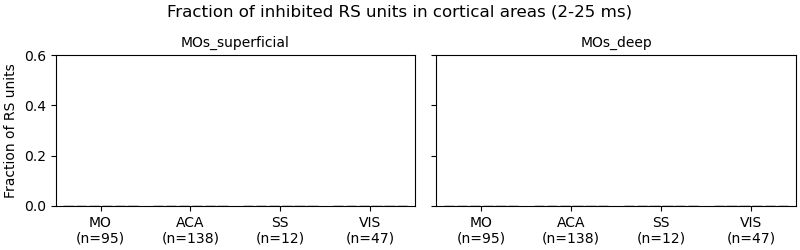

In [31]:
plot_cell_type = 'RS'
plot_response_type = 'excited' # excited, inhibited
plot_rwin = 'early' # early, mid, late

fig, axs = plt.subplots(1, len(exp_unit_stats), figsize=(8,2.5), sharex=True, sharey=True, constrained_layout=True)
for expi, (plexp, df) in enumerate(exp_unit_stats.items()):
    labels = []
    for ri, region in enumerate(ROI):
        for ii, parami in enumerate(current_level):
            for jj, statei in enumerate(test_states):
                uresp = df['response_type'][(
                    (df['parent'] == region) &
                    (df['cell_type'] == plot_cell_type) &
                    (df['stim_level'] == parami) &
                    (df['state'] == statei) &
                    (df['response_stage'] == plot_rwin)
                )].values
                fraction_resp = np.sum(uresp == plot_response_type) / len(uresp)
                xloc = barlocs[ri, 2*ii+jj]
                axs[expi].bar(xloc, fraction_resp, width=0.8, color=current_colors[ii], edgecolor='k', hatch=state_hatch[jj])
                if (ii == 0) & (jj == 0):
                    labels.append('{}\n(n={:d})'.format(region, len(uresp)))
    axs[expi].set_title(plexp)
axs[0].set_xlim([barlocs[0,0]-1, barlocs[-1,-1]])
axs[0].set_xticks(np.mean(barlocs[:,:-1], axis=1))
axs[0].set_xticklabels(labels)
axs[0].set_ylim([0, 0.6])
axs[0].set_ylabel('Fraction of {} units'.format(plot_cell_type))
plt.suptitle('Fraction of {} {} units in cortical areas ({:d}-{:d} ms)'.format(
    plot_response_type, plot_cell_type, int(response_window[plot_rwin][0]*1E3), int(response_window[plot_rwin][1]*1E3)
), fontsize=12) # , color='r')

## Save ##
figname = 'fractresp_{}_{}_{}.png'.format(plot_rwin, plot_response_type, plot_cell_type)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=False)

Plot evoked firing rates. Plot a bar instead?? Plot as baseline subtracted??

<IPython.core.display.Javascript object>


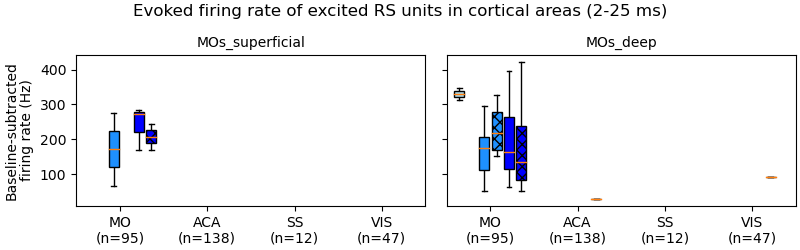

In [30]:
plot_cell_type = 'RS'
plot_response_type = 'excited' # excited, inhibited
plot_rwin = 'early' # early, mid, late

fig, axs = plt.subplots(1, len(exp_unit_stats), figsize=(8,2.5), sharex=True, sharey=True, constrained_layout=True)
for expi, (plexp, df) in enumerate(exp_unit_stats.items()):
    labels = []
    for ri, region in enumerate(ROI):
        for ii, parami in enumerate(current_level):
            for jj, statei in enumerate(test_states):
                uresp = df['response_type'][(
                    (df['parent'] == region) & (df['cell_type'] == plot_cell_type) & (df['stim_level'] == parami) &
                    (df['state'] == statei) & (df['response_stage'] == plot_rwin)
                )].values
                blFR = df['BLFR_' + statei][(
                    (df['parent'] == region) & (df['cell_type'] == plot_cell_type) & (df['stim_level'] == parami) &
                    (df['state'] == statei) & (df['response_stage'] == plot_rwin)
                )].values
                uFR = df['evokedFR'][(
                    (df['parent'] == region) & (df['cell_type'] == plot_cell_type) & (df['stim_level'] == parami) &
                    (df['state'] == statei) & (df['response_stage'] == plot_rwin)
                )].values
                FR = uFR[uresp == plot_response_type] - blFR[uresp == plot_response_type]
                xloc = barlocs[ri, 2*ii+jj]
                if len(FR) > 0:
                    ## plot bar ##
#                     axs[expi].bar(xloc, np.mean(FR), width=0.8, color=current_colors[ii], edgecolor='k', hatch=state_hatch[jj])
                    ## plot box ##
                    bbox = axs[expi].boxplot(FR, positions=[xloc], widths=0.8, patch_artist=True, showfliers=False)
                    plt.setp(bbox['boxes'], facecolor=current_colors[ii], hatch=state_hatch[jj])
                if (ii == 0) & (jj == 0):
                    labels.append('{}\n(n={:d})'.format(region, len(uresp)))
    axs[expi].set_title(plexp)
axs[0].set_xlim([barlocs[0,0]-1, barlocs[-1,-1]])
axs[0].set_xticks(np.mean(barlocs[:,:-1], axis=1))
axs[0].set_xticklabels(labels)
axs[0].set_ylabel('Baseline-subtracted\nfiring rate (Hz)')
plt.suptitle('Evoked firing rate of {} {} units in cortical areas ({:d}-{:d} ms)'.format(
    plot_response_type, plot_cell_type, int(response_window[plot_rwin][0]*1E3), int(response_window[plot_rwin][1]*1E3)
), fontsize=12) #, color='r')

## Save ##
figname = 'evokedFR_{}_{}_{}.png'.format(plot_rwin, plot_response_type, plot_cell_type)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=True)

Plot baseline firing rate

In [33]:
stlocs = np.arange((len(state_hatch) + 1) * len(ROI))
stlocs = stlocs.reshape((len(ROI), (len(state_hatch) + 1)))

<IPython.core.display.Javascript object>


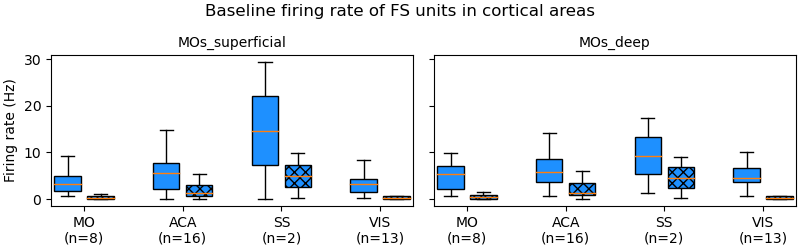

In [37]:
plot_cell_type = 'FS'

fig, axs = plt.subplots(1, len(exp_unit_info), figsize=(8,2.5), sharex=True, sharey=True, constrained_layout=True)
for expi, (plexp, df) in enumerate(exp_unit_info.items()):
    labels = []
    for ri, region in enumerate(ROI):
        for jj, statei in enumerate(test_states):
            plot_met = df['BLFR_' + statei][((df['parent'] == region) & (df['cell_type'] == plot_cell_type))].values
            xloc = stlocs[ri, jj]
            bbox = axs[expi].boxplot(plot_met, positions=[xloc], widths=0.8, patch_artist=True, showfliers=False)
            plt.setp(bbox['boxes'], facecolor=current_colors[1], hatch=state_hatch[jj])
            if jj == 0:
                labels.append('{}\n(n={:d})'.format(region, len(plot_met)))
    axs[expi].set_xticks(np.mean(stlocs[:,:-1], axis=1))
    axs[expi].set_xticklabels(labels)
    axs[expi].set_title(plexp)

axs[0].set_ylabel('Firing rate (Hz)')
plt.suptitle('Baseline firing rate of {} units in cortical areas'.format(plot_cell_type), fontsize=12) # , color='r')

## Save ##
figname = 'BLfiringrate_{}.png'.format(plot_cell_type)
# fig.savefig(os.path.join(plotsavedir, figname), transparent=False)

### Need to re-factor plots below for new data format

#### Examine responsive cells in different cortical regions for one stim depth

In [23]:
barcolors = ['lightblue', 'dodgerblue', 'blue']
state_hatch = [None, 'xxx']

In [24]:
ROI = ['MO', 'ACA', 'SS', 'VIS']
plot_cell_type = 'RS'
plexp = 'antMOs_1200'

In [25]:
test_states = list(comp_states[plexp].keys())
currents = list(unit_responses[plexp].keys())

barlocs = np.arange((len(currents) * len(test_states) + 1) * len(ROI))
barlocs = barlocs.reshape((len(ROI), (len(currents) * len(test_states) + 1)))

In [35]:
plot_response_type = 'excited'
plot_rwin = 'initial'

fig, ax = plt.subplots(figsize=(6,4))
labels = []
for ri, (region) in enumerate(ROI):
    for ii, parami in enumerate(currents):
        for jj, statei in enumerate(test_states):
            df = unit_responses[plexp][parami][statei]
            uresp = df[plot_rwin][(df['parent'] == region) & (df['cell_type'] == plot_cell_type)].values
            fraction_resp = np.sum(uresp == plot_response_type) / len(uresp)
            xloc = barlocs[ri, 2*ii+jj]
            ax.bar(xloc, fraction_resp, width=0.8, color=barcolors[ii], edgecolor='k', hatch=state_hatch[jj])
            if (ii == 0) & (jj == 0):
                labels.append('{}\n(n={:d})'.format(region, len(uresp)))
            
ax.set_ylim(0,1)
ax.set_ylabel('Fraction of {} units'.format(plot_cell_type))
ax.set_title('Fraction of {} {} units in cortical areas'.format(plot_response_type, plot_cell_type))
ax.set_xticks(np.mean(barlocs[:,:-1], axis=1))
ax.set_xticklabels(labels)

<IPython.core.display.Javascript object>

[Text(2.5, 0, 'MO\n(n=95)'),
 Text(9.5, 0, 'ACA\n(n=138)'),
 Text(16.5, 0, 'SS\n(n=12)'),
 Text(23.5, 0, 'VIS\n(n=47)')]

Example single response type

In [61]:
ROI = ['MO', 'ACA', 'SS', 'VIS']
plot_cell_type = 'RS'
plexp = 'antMOs_1200'
plstim = '40'
plstate = 'awake' # 'anesthetized' 'awake'

df = unit_responses[plexp][plstim][plstate]

<IPython.core.display.Javascript object>


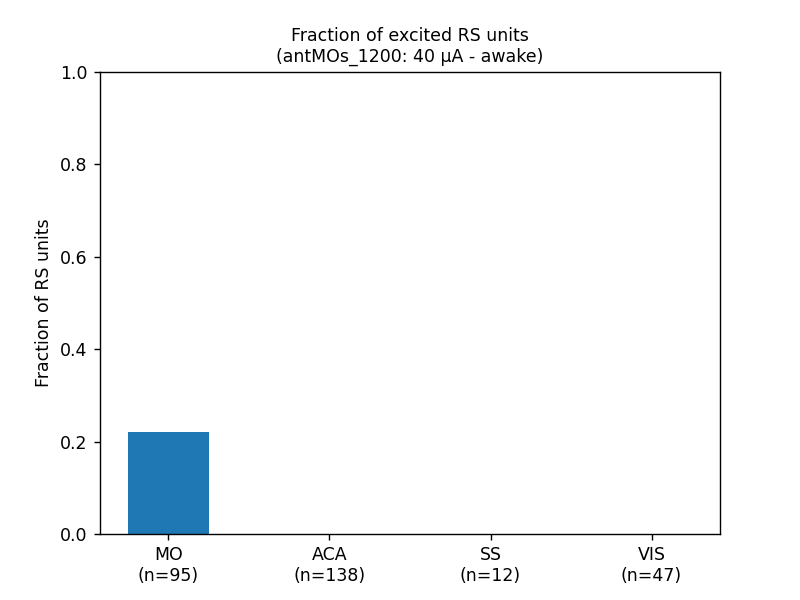

Text(0.5, 1.0, 'Fraction of excited RS units\n(antMOs_1200: 40 μA - awake)')

In [62]:
plot_response_type = 'excited'
plot_rwin = 'initial'

labels = []
fraction_list = []
for regi in ROI:
    uresp = df[plot_rwin][(df['parent'] == regi) & (df['cell_type'] == plot_cell_type)].values
    fraction_list.append(np.sum(uresp == plot_response_type) / len(uresp))
    labels.append('{}\n(n={:d})'.format(regi, len(uresp)))
    
fig, ax = plt.subplots()
ax.bar(labels, fraction_list, width=0.5)
ax.set_ylim(0,1)
ax.set_ylabel('Fraction of {} units'.format(plot_cell_type))
ax.set_title('Fraction of {} {} units\n({}: {} \u03bcA - {})'.format(
    plot_response_type, plot_cell_type, plexp, plstim, plstate))

In [ ]:
test_states = ['awake', 'anesthetized']
barlocs = np.arange((len(currents_list) * len(test_states) + 1) * len(pop_spikes.keys()))
barlocs = barlocs.reshape((len(pop_spikes.keys()), (len(currents_list) * len(test_states) + 1)))

barcolors = ['lightblue', 'dodgerblue', 'blue']
state_hatch = [None, 'xxx']

Test for single units

In [63]:
df[(
    (df['parent'] == 'MO') &
    (df['cell_type'] == plot_cell_type) &
    (df['initial'] == plot_response_type)
)].unit_id.values

array(['F421', 'F434', 'F451', 'F455', 'F457', 'F466', 'F471', 'F481',
       'F492', 'F501', 'F505', 'F508', 'F524', 'F525', 'F527', 'F528',
       'F529', 'F536', 'F554', 'F563', 'F575'], dtype=object)

In [64]:
df[(
    (df['parent'] == 'MO') &
    (df['cell_type'] == plot_cell_type)
)].unit_id.values

array(['F417', 'F418', 'F415', 'F724', 'F411', 'F419', 'F421', 'F426',
       'F683', 'F432', 'F431', 'F434', 'F685', 'F437', 'F442', 'F445',
       'F446', 'F449', 'F450', 'F451', 'F455', 'F456', 'F457', 'F466',
       'F471', 'F691', 'F477', 'F485', 'F481', 'F486', 'F695', 'F727',
       'F493', 'F492', 'F499', 'F501', 'F502', 'F505', 'F507', 'F508',
       'F511', 'F696', 'F512', 'F698', 'F518', 'F522', 'F524', 'F532',
       'F525', 'F527', 'F528', 'F529', 'F700', 'F701', 'F533', 'F536',
       'F540', 'F545', 'F549', 'F551', 'F552', 'F728', 'F706', 'F704',
       'F555', 'F554', 'F556', 'F558', 'F553', 'F563', 'F566', 'F568',
       'F572', 'F570', 'F575', 'F709', 'F577', 'F578', 'F579', 'F581',
       'F583', 'F584', 'F710', 'F592', 'F596', 'F597', 'F602', 'F598',
       'F600', 'F609', 'F614', 'F737', 'F627', 'F630', 'F718'],
      dtype=object)

In [65]:
time_bin = 0.0001 # size of time bins (s)
bins = np.arange(raster_window[0], raster_window[1] + time_bin, time_bin)
timex = bins[:-1] + time_bin/2
sigshort = 5 # Gaussian kernel length (Butovas&Schwarz2003 use short kernel for first excitatory response)
siglong = 50 # Gaussian kernel length (Butovas&Schwarz2003 use long kernel for rest of response)

<IPython.core.display.Javascript object>


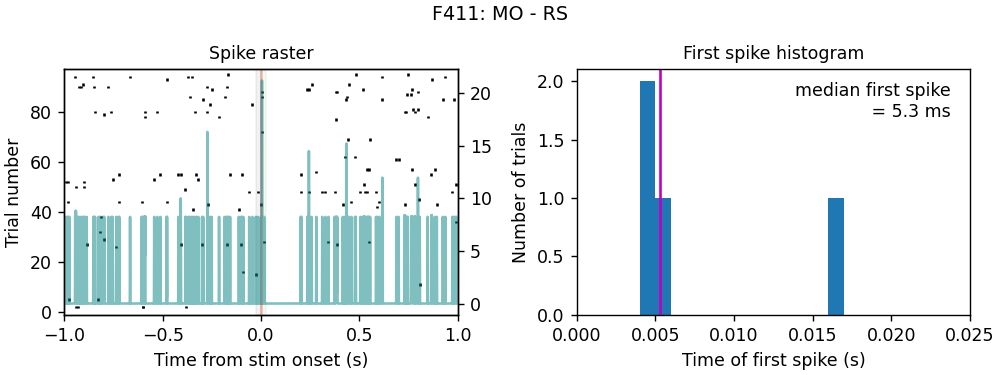

Text(0.5, 0.98, 'F411: MO - RS')

In [96]:
uniti = 'F411'

fig, axs = plt.subplots(1, 2, figsize=(8,3), constrained_layout=True)
## Spike raster ##
axs[0].axvline(0, color='r', alpha=0.25)
axs[0].axvspan(-response_window['initial'][1], -response_window['initial'][0], color='k', alpha=0.05)
axs[0].axvspan(response_window['initial'][0], response_window['initial'][1], color='g', alpha=0.05)

first_spikes = []
spike_rate = []
for indi, spikes in enumerate(unit_trial_spikes[plexp][plstim][plstate][uniti]):
    if not isinstance(spikes, np.ndarray):
        spikes = np.array([spikes])
    axs[0].eventplot([spikes], lineoffsets=indi, linelengths=0.95, color='black')
    
    early_spikes = np.nonzero((spikes > 0) & (spikes < response_window['initial'][1]))[0]
    if len(early_spikes) > 0:
        first_spikes.append(spikes[early_spikes[0]])
        
    sp_counts, edges = np.histogram(spikes, bins)
    spike_rate.append(sp_counts/time_bin)
    
axs[0].set_xlim(raster_window)
axs[0].set_ylim([-1, indi+1])
axs[0].set_xlabel('Time from stim onset (s)')
axs[0].set_ylabel('Trial number')
axs[0].set_title('Spike raster')

unitFR = np.mean(np.array(spike_rate), axis=0)
unitSDF = ndimage.gaussian_filter(unitFR, sigma=sigshort, output=float)
sdfax = axs[0].twinx()
sdfax.plot(timex, unitSDF, color='teal', alpha=0.5)

## First spike histogram ##
n, obins, patches = axs[1].hist(first_spikes, bins=np.arange(0, response_window['initial'][1]+0.001, 0.001))
axs[1].set_xlabel('Time of first spike (s)')
axs[1].set_ylabel('Number of trials')
axs[1].set_title('First spike histogram')
axs[1].set_xlim([obins[0], obins[-1]])
axs[1].axvline(np.median(first_spikes), color='m')
axs[1].text(
    0.95, 0.95, 'median first spike\n = {:.1f} ms'.format(np.median(first_spikes)*1E3),
    ha='right', va='top', transform=axs[1].transAxes, fontsize=10
)
plt.suptitle('{}: {} - {}'.format(uniti, 'MO', plot_cell_type), fontsize=11)

<IPython.core.display.Javascript object>


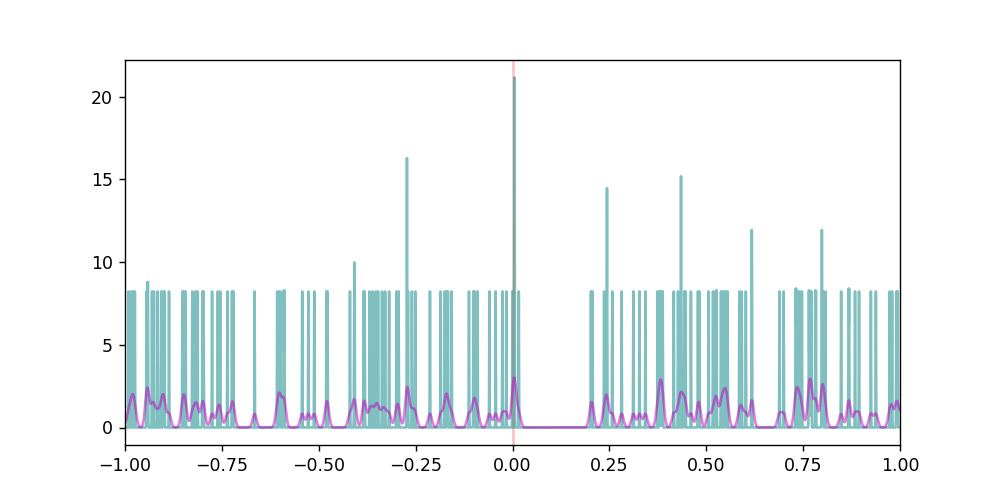

(-1.0, 1.0)

In [97]:
shSDF = ndimage.gaussian_filter(unitFR, sigma=sigshort, output=float)
lSDF = ndimage.gaussian_filter(unitFR, sigma=siglong, output=float)

fig, ax = plt.subplots(figsize=(8,4))
ax.axvline(0, color='r', alpha=0.25)
ax.plot(timex, shSDF, color='teal', alpha=0.5)
ax.plot(timex, lSDF, color='m', alpha=0.5)
ax.set_xlim(raster_window)